# Plot the seasonal mean of the variable _snowfall_

In [1]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from glob import glob

### Create dask cluster to work parallel in large datasets

from dask.distributed import Client
client = Client(n_workers=2, 
                threads_per_worker=2, 
                memory_limit='4GB',
                processes=False)
client
chunks={'time' : 10,}
client

Client Scheduler: inproc://10.0.0.63/501579/1 Dashboard: http://10.0.0.63:36675/status,Cluster Workers: 2 Cores: 4 Memory: 8.00 GB


In [2]:
_path = '/home/franzihe/nird_franzihe/data/ERA5/'
var = 'sf'

In [3]:
fn_list = [ff for ff in glob(_path + var + '_Amon_*.nc') if (int(ff[-9:-5])>1985)]
fn_list.sort()

if len(fn_list) > 0:
    fn = xr.open_mfdataset(fn_list, chunks = chunks, 
                           parallel = True, 
                           use_cftime = False,
                          ) 
#    fn['time'] = fn.indexes['time'].to_datetimeindex()

In [4]:
fn

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 360)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1985-01-01 1985-02-01 ... 2014-12-01
Data variables:
    sf         (time, latitude, longitude) float32 dask.array<chunksize=(10, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-19 08:28:56 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

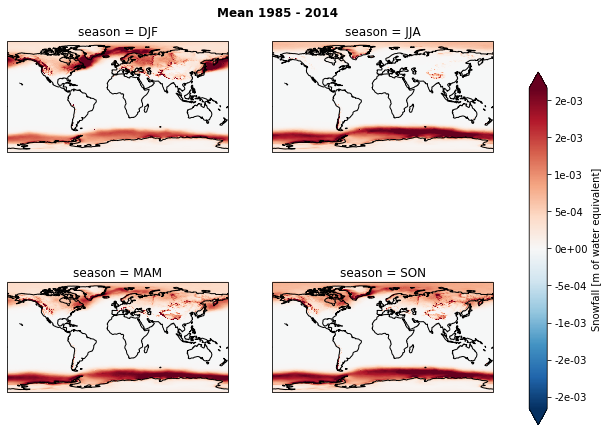

In [5]:
f,axsm = plt.subplots(2,2, figsize = [10,7], subplot_kw={'projection' : ccrs.PlateCarree()})
axs = axsm.flatten()
for sea, ax in zip(fn.sf.groupby('time.season').sum('time').season, axs.flatten()):
    im = fn.sf.sel(time = (fn.sf['time.season'] == sea),).mean('time', keep_attrs = True).plot.pcolormesh(ax = ax,
                                                                                                          transform = ccrs.PlateCarree(),
                                                                                                          robust = True,
                                                                                                          add_colorbar = False)
    ax.coastlines()
f.subplots_adjust(right = 0.8, top = 1.0)
f.suptitle('Mean {starty} - {endy}'.format(starty = np.asarray(fn['time.year'][0]),  endy = np.asarray(fn['time.year'][-1])), fontweight = 'bold')
cbar_ax = f.add_axes([0.85, 0.15, 0.025, 0.7])
f.colorbar(im, 
               cax=cbar_ax, 
               extend = 'both',
               format='%.0e').ax.set_ylabel(fn.sf.attrs['long_name'] + ' [' + fn.sf.attrs['units'] + ']')
plt.tight_layout()